# Movie Maturity rating prediction

In [1]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors

In [2]:
df = pd.read_csv('movie_cleaned.csv')
df.head()
g = df.groupby('rating')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df = g.droplevel(0)
df = df.sample(frac=1).reset_index(drop=True)

# Clean Texts

In [3]:
from nltk.corpus import stopwords
import nltk
import re
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def containsNum(string):
    RE_D = re.compile('\d')
    return RE_D.search(string)
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = ' '.join(word for word in text.split() if not containsNum(word)) #remove numbers
    return text

In [5]:
clean_text('seventeen-year-old')

'seventeen year old'

In [6]:
df['synopsis_clean'] = df['synopsis'].apply(clean_text)

In [7]:
df.head()

,movie_title,synopsis,rating,synopsis_clean
0,Pray for Rain,A young New York journalist returns to the idy...,PG13,young new york journalist returns idyllic cent...
1,Scooby-Doo 2: Monsters Unleashed,"In Scooby-Doo 2: Monsters Unleashed, the teena...",PG,scooby doo monsters unleashed teenage detectiv...
2,Filth,Bruce Robertson (James McAvoy) is a Detective ...,R21,bruce robertson james mcavoy detective sergean...
3,EverAfter,The Queen of France summons the Grimm Brothers...,PG,queen france summons grimm brothers producing ...
4,Before I Fall,Sam wakes up at 6:50 to a text from her boyfri...,PG13,sam wakes text boyfriend saying happy cupid da...


# Load pretrained glove vectors

In [8]:
%%time
# load the Stanford GloVe model
filename = 'glove.6B.300d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['god'], topn=1)
print(result)

[('queen', 0.5355600118637085)]
Wall time: 2min 22s


# Get Intensity

In [34]:
class Intensity:
    def __init__(self,topic,int_vect):
        self.topic = topic
        self.int_vect = int_vect
    def get_intensity(self,word):
        """
        projects word onto intensity vector to get intensity 
        multiply by similarity to topic to reduce weight of irrelevant words
        """
        return model.similarity(w1=self.topic,w2=word)*np.dot(model[word],self.int_vect)/np.linalg.norm(self.int_vect)
    def get_similarity(self,word):
        return model.similarity(w1=self.topic,w2=word)
    def get_factor(self,text,function='intensity'):
#         print('f',function)
        sum1 = 0
        arr = text.split()
        for word in arr:
            try:
                if function == 'intensity':
                    value = self.get_intensity(word)
                else:
                    value = self.get_similarity(word)
                if value<0:
                    value= 0.01
#                 elif value>1:
#                     value = 1
                sum1+=value
            except:
                pass
        return sum1/len(arr)
        
        

In [35]:
sexual_vector = model['intercourse'] - model['chastity']
Sexual_intensity = Intensity('sexual',sexual_vector)
print(Sexual_intensity.get_intensity('nude'))
print(Sexual_intensity.get_intensity('rape'))
print(Sexual_intensity.get_intensity('sex'))
print(Sexual_intensity.get_intensity('run'))
print(Sexual_intensity.get_intensity('him'))
print(Sexual_intensity.get_intensity('her'))

0.1799409
0.95540994
1.2835717
-0.0074890708
0.114342056
-0.029518781


In [36]:
%%time 
df['sex_similarity'] = df['synopsis_clean'].apply(Sexual_intensity.get_factor,args=('similarity',))
df['sex_factor'] = df['synopsis_clean'].apply(Sexual_intensity.get_factor)

Wall time: 1min 22s


In [37]:
df.head()

,movie_title,synopsis,rating,synopsis_clean,sex_similarity,sex_factor,violence_factor,violence_similarity
0,Pray for Rain,A young New York journalist returns to the idy...,PG13,young new york journalist returns idyllic cent...,0.165630,0.058677,0.052804,0.258055
1,Scooby-Doo 2: Monsters Unleashed,"In Scooby-Doo 2: Monsters Unleashed, the teena...",PG,scooby doo monsters unleashed teenage detectiv...,0.098532,0.032562,0.052309,0.126072
2,Filth,Bruce Robertson (James McAvoy) is a Detective ...,R21,bruce robertson james mcavoy detective sergean...,0.154929,0.075726,0.043212,0.177944
3,EverAfter,The Queen of France summons the Grimm Brothers...,PG,queen france summons grimm brothers producing ...,0.100164,0.035658,0.022734,0.120402
4,Before I Fall,Sam wakes up at 6:50 to a text from her boyfri...,PG13,sam wakes text boyfriend saying happy cupid da...,0.137812,0.056279,0.029503,0.168910


# Violence

In [38]:
violence_vect = model['kill'] - model['peace']
Violence_intensity = Intensity("violence",violence_vect)

In [39]:
print(Violence_intensity.get_intensity('rape'))
print(Violence_intensity.get_intensity('murder'))
print(Violence_intensity.get_intensity('fight'))
print(Violence_intensity.get_intensity('punch'))
print(Violence_intensity.get_intensity('slaughter'))
print(Violence_intensity.get_intensity('kill'))

0.5524363
0.5967657
0.06181001
0.061893966
0.34266934
1.0035129


In [40]:
%%time 
df['violence_factor'] = df['synopsis_clean'].apply(Violence_intensity.get_factor)
df['violence_similarity'] = df['synopsis_clean'].apply(Violence_intensity.get_factor,args=('similarity',))

Wall time: 1min 19s


In [41]:
avg_factor = df.groupby(['rating']).mean()
avg_factor

,sex_similarity,sex_factor,violence_factor,violence_similarity
rating,,,,
M18,0.121029,0.052414,0.033414,0.149016
NC16,0.118250,0.049171,0.032539,0.149782
PG,0.111607,0.045445,0.027671,0.141974
PG13,0.116158,0.048183,0.029594,0.147636
R21,0.125734,0.057915,0.033660,0.150382


In [42]:
def print_factor_diff(name):
    print(name,(max(avg_factor[name]) - min(avg_factor[name]))/min(avg_factor[name]))
print("Ratio of differences")
print_factor_diff('sex_factor')
print_factor_diff('sex_similarity')
print_factor_diff('violence_factor')
print_factor_diff('violence_similarity')

Ratio of differences
sex_factor 0.2744050527326036
sex_similarity 0.12658188460913586
violence_factor 0.2164459404189893
violence_similarity 0.059216983050526174


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
x_train, x_test, y_train, y_test = train_test_split(np.array(df[['sex_factor','violence_factor','sex_similarity','violence_similarity']]), df['rating'], test_size=0.1, random_state=8)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression(C=10)
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         M18       0.20      0.05      0.08        39
        NC16       0.32      0.22      0.26        41
          PG       0.24      0.59      0.34        37
        PG13       0.25      0.07      0.11        42
         R21       0.33      0.47      0.39        45

    accuracy                           0.28       204
   macro avg       0.27      0.28      0.24       204
weighted avg       0.27      0.28      0.24       204



C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [45]:
def ordinalise(rating):
    ordinal_dict = {'PG':0,'PG13':1,'NC16':2,'M18':3,'R21':4}
    return ordinal_dict[rating]
df['ordinal_rating'] =  df['rating'].apply(lambda x:ordinalise(x))

In [46]:
df.groupby('rating').mean()

,sex_similarity,sex_factor,violence_factor,violence_similarity,ordinal_rating
rating,,,,,
M18,0.121029,0.052414,0.033414,0.149016,3
NC16,0.118250,0.049171,0.032539,0.149782,2
PG,0.111607,0.045445,0.027671,0.141974,0
PG13,0.116158,0.048183,0.029594,0.147636,1
R21,0.125734,0.057915,0.033660,0.150382,4


In [47]:
def transform(text_arr,intensity,function='intensity'):
    sum1 = np.zeros(model['the'].shape,dtype='float64') #get shape of a random word then set it to zero
    for text in text_arr:
        try:
            if function == 'intensity':
                int_value = intensity.get_intensity(text)
            else:
                int_value = intensity.get_similarity(text)
#             if int_value<0:
#                 int_value = 0.001 # small weight if negative relation
            sum1 += model[text]*np.exp(int_value)
        except:
            pass
    return sum1/len(text_arr)

In [48]:
def vectorise(text_matrix,intensity,function='intensity'):
    ls = []
    for text_arr in text_matrix:
        vector = transform(text_arr,intensity,function)
        ls.append(vector)
    return np.array(ls)

In [49]:
X_syn = df['synopsis_clean'].apply(lambda text: text.split(' ')).values

In [50]:
%%time
X_sex_intensity = vectorise(X_syn,Sexual_intensity)
X_sex_similarity = vectorise(X_syn,Sexual_intensity,'similarity')
X_violence_intensity = vectorise(X_syn,Violence_intensity)
X_violence_similarity = vectorise(X_syn,Violence_intensity,'similarity')

Wall time: 2min 48s


In [110]:
X = np.hstack([X_violence_intensity,X_sex_intensity])
y = df['ordinal_rating']

In [111]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

In [112]:
def lax_evaluate(a,b):
    return np.average(np.abs(b-a)<2)

In [113]:
lclf = LogisticRegression(C=1)
lclf.fit(x_train,y_train)
prediction = lclf.predict(x_test)
print(classification_report(y_test,prediction))
lax_evaluate(y_test,prediction)

C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.53      0.58      0.55        50
           1       0.36      0.36      0.36        36
           2       0.18      0.13      0.15        39
           3       0.32      0.33      0.32        39
           4       0.50      0.55      0.52        40

    accuracy                           0.40       204
   macro avg       0.38      0.39      0.38       204
weighted avg       0.39      0.40      0.39       204



0.7009803921568627

In [114]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(10,),learning_rate='adaptive',alpha=0.0001,early_stopping=True)
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
print(classification_report(y_test,prediction))
print(lax_evaluate(y_test,prediction))

              precision    recall  f1-score   support

           0       0.48      0.64      0.55        50
           1       0.29      0.22      0.25        36
           2       0.32      0.18      0.23        39
           3       0.38      0.31      0.34        39
           4       0.47      0.65      0.55        40

    accuracy                           0.42       204
   macro avg       0.39      0.40      0.38       204
weighted avg       0.39      0.42      0.39       204

0.6666666666666666


In [115]:
lax_evaluate(y_test,prediction)

0.6666666666666666

In [116]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(clf,X,y,cv=10,scoring='neg_mean_squared_error'))

-2.116426829268293

In [117]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(lclf,X,y,cv=10,scoring='neg_mean_squared_error'))

C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

-2.2623170731707316

In [118]:
from sklearn.base import BaseEstimator
import numpy as np
class OrdClass(BaseEstimator):
  """
  Helper class that solves ordinal classification (classes that have an order to them eg cold,warm,hot)
  """
  def __init__(self,classifier=None,clf_args=None):
    """
    y needs to be a number that start from 0 and increments by 1
    classifier object needs to be able to return a probability
    """
    self.classifier = classifier
    self.clfs = []
    self.clf_args = clf_args
    self.final_prob = None
  
  def fit(self,X,y,**fit):
    self.X = X
    self.y = y
    import copy
    no_of_classifiers = np.max(self.y) #since y starts from 0
    self.classes_ = list(range(no_of_classifiers+1))
    if isinstance(self.clf_args,list):
      #for pipelines
      c = self.classifier(self.clf_args)
    elif isinstance(self.clf_args,dict):
      #for normal estimators
       c = self.classifier(**self.clf_args)
    for i in range(no_of_classifiers):
      # make a copy of y because we want to change the values of y
      copy_y = np.copy(self.y)
      # make a binary classification here
      copy_y[copy_y<=i] = 0
      copy_y[copy_y>i] = 1
      classifier = copy.deepcopy(c)
      classifier.fit(self.X,copy_y,**fit)
      self.clfs.append(classifier)
    return self
  def predict_proba(self,test):
    prob_list = []
    final_prob = []
    length = len(self.clfs)
    for clf in self.clfs:
      prob_list.append(clf.predict_proba(test)[:,1])
    for i in range(length+1):
      if i == 0:
        final_prob.append(1-prob_list[i])
      elif i == length:
        final_prob.append(prob_list[i-1])
      else:
        final_prob.append(prob_list[i-1]-prob_list[i])
    answer = np.array(final_prob).transpose()
    self.final_prob= answer
    return answer
  def predict(self,test):
    self.predict_proba(test)
    return np.argmax(self.final_prob,axis=1)
  def score(self,X,y,sample_weight=None):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [119]:
# args = {'hidden_layer_sizes':(10,),'learning_rate':'adaptive',"alpha":0.001}
# o = OrdClass(MLPClassifier,args)
args = {'C':1}
o = OrdClass(LogisticRegression,args)
o.fit(x_train,y_train)
prediction = o.predict(x_test)
print(classification_report(y_test,prediction))
print(lax_evaluate(y_test,prediction))

C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.60      0.52      0.56        50
           1       0.34      0.39      0.36        36
           2       0.29      0.31      0.30        39
           3       0.29      0.33      0.31        39
           4       0.64      0.53      0.58        40

    accuracy                           0.42       204
   macro avg       0.43      0.41      0.42       204
weighted avg       0.44      0.42      0.43       204

0.7450980392156863


In [120]:
def show_confusion_matrix(conf_mat,classifier):
  import seaborn as sn
  import matplotlib.pyplot as plt
  labels = classifier.classes_
  df_cm = pd.DataFrame(conf_mat, index = [i for i in labels ],
                  columns = [i for i in labels])
  plt.figure(figsize = (10,7))
  s= sn.heatmap(df_cm, annot=True,fmt='d',cmap='Blues')
  s.set(xlabel="predicted",ylabel="actual")
  bottom, top = s.get_ylim()
  s.set_ylim(bottom + 0.5, top - 0.5)
  plt.show()

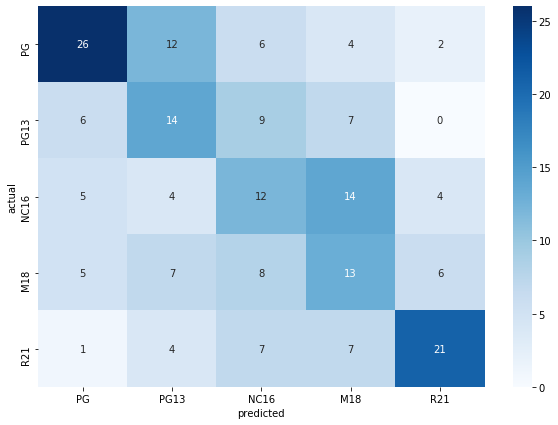

In [121]:
o.classes_ = ["PG","PG13","NC16","M18","R21"]
cm = confusion_matrix(y_test,prediction)
show_confusion_matrix(cm,o)

In [122]:
np.mean(cross_val_score(o,X,y,cv=10,scoring='neg_mean_squared_error'))

C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

-1.9254901960784316

In [123]:
#args = {'hidden_layer_sizes':(100,),'learning_rate':'adaptive',"alpha":0.0001,'early_stopping':True,'n_iter_no_change':20,'validation_fraction':0.2}
args = {'hidden_layer_sizes':(100,),'max_iter':800}
o1 = OrdClass(MLPClassifier,args)
o1.fit(x_train,y_train)
prediction = o1.predict(x_test)
print(classification_report(y_test,prediction))
print(lax_evaluate(y_test,prediction))

              precision    recall  f1-score   support

           0       0.64      0.36      0.46        50
           1       0.23      0.31      0.26        36
           2       0.24      0.28      0.26        39
           3       0.23      0.28      0.25        39
           4       0.47      0.40      0.43        40

    accuracy                           0.33       204
   macro avg       0.36      0.33      0.33       204
weighted avg       0.38      0.33      0.34       204

0.7401960784313726


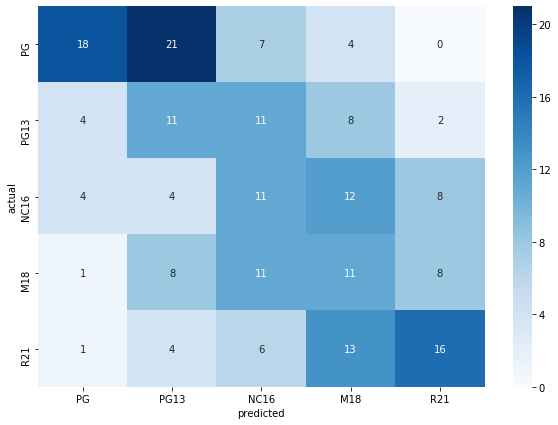

In [124]:
o1.classes_ = ["PG","PG13","NC16","M18","R21"]
cm = confusion_matrix(y_test,prediction)
show_confusion_matrix(cm,o1)

In [ ]:
np.mean(cross_val_score(o1,X,y,cv=10,scoring='neg_mean_squared_error',n_jobs=-1))

C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\garyo\Anaconda3\lib\site-packages\sklearn\neural_ne

In [ ]:
# for i in range(50,1200,50):
#     args = {'hidden_layer_sizes':(i,),"alpha":0.0001,'max_iter':800}
#     o1 = OrdClass(MLPClassifier,args)
#     o1.fit(x_train,y_train)
#     prediction = o1.predict(x_test)
#     print("i is",i)
#     print(classification_report(y_test,prediction))
#     print(lax_evaluate(y_test,prediction))